In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import datetime
import numpy as np
import pandas as pd

import matplotlib.cm  as cm
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from tensorflow import keras

sys.path.append( '..' )
from utils import LP_PSDs, LP_datos, plot_LP_list

In [2]:
tf.config.list_physical_devices()
# %load_ext tensorboard

2021-11-15 15:06:03.966881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:06:04.019065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:06:04.019272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Hasta ahora hemos visto que la combinación TSNE+GMM nos da unos resultados que permite entrenar un clasificador con muy buena precision.
Sin embargo, no hemos discutido sobre la extracción de parametros que, de alguna forma, es la base de nuestros resultados.

EL objetivo de este cuaderno es aplicar Redes Nauronales, y en particular AutoEncoders, para la extracción de parametros que permita mejorar la selección de clusters en el TSNE+GMM. 

Vamos a trabajar en el dominio espectral de la señal. Así que aplicaremos una nfft que permita describir el contenido espectral de todas las señales con el mismo tamaño. De esta forma, cada señal vendra parametrizada por su PSD que tiene un tamaño dado por la fq_size. 

In [2]:
x_all, (x_train, x_test) = LP_PSDs(test_size=0.5)
fq_size = x_train.shape[1]

X_all = x_all.reshape(x_all.shape[0], fq_size, 1)
X_test = x_test.reshape(x_test.shape[0], fq_size, 1)
X_train =x_train.reshape(x_train.shape[0], fq_size, 1)

## Simple AutoEncoder

In [3]:
keras.backend.clear_session()
input_img = keras.layers.Input(shape=(fq_size,))
encoded = keras.layers.Dense(15, activation='relu')(input_img)
decoded = keras.layers.Dense(fq_size, activation='sigmoid')(encoded)
AE = keras.models.Model(input_img, decoded)
keras.utils.plot_model(AE, show_shapes=True)
AE.summary()

2021-11-15 20:10:13.195333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 20:10:13.221276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 20:10:13.221460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 20:10:13.221937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 97)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                1470      
_________________________________________________________________
dense_1 (Dense)              (None, 97)                1552      
Total params: 3,022
Trainable params: 3,022
Non-trainable params: 0
_________________________________________________________________


2021-11-15 20:10:16.775064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
14/14 [==============================] - 1s 9ms/step - loss: 0.6892 - val_loss: 0.6788
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6680 - val_loss: 0.6505
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6317 - val_loss: 0.6022
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5748 - val_loss: 0.5358
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5064 - val_loss: 0.4698
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4476 - val_loss: 0.4254
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4126 - val_loss: 0.4034
Epoch 8/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3950 - val_loss: 0.3920
Epoch 9/200
14/14 [==============================] - 0s 4ms/step - loss: 0.3852 - val_loss: 0.3848
Epoch 10/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3790 - val_loss: 0.3797
Epoch 11/

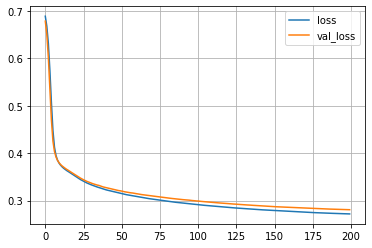

In [4]:
AE.compile(optimizer='adam', loss='binary_crossentropy')
history = AE.fit(x_train, x_train,
                epochs=200,
                batch_size=40,
                shuffle=True,
                validation_data=(x_test, x_test)
                )
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

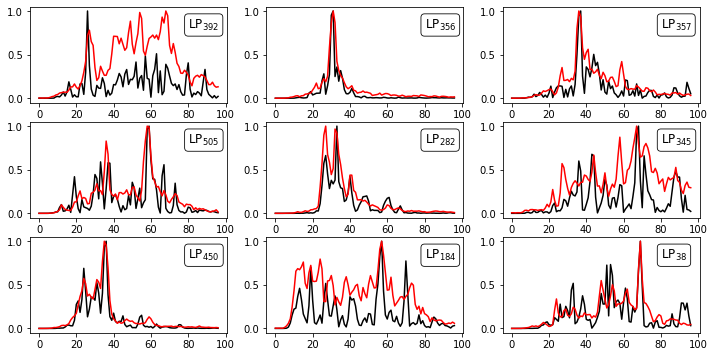

In [14]:
x_pred = AE.predict(x_test)
x_index = np.arange(x_test.shape[0])
x_some = x_index[np.random.choice(x_test.shape[0], 9, replace=False)]

plt.figure(figsize=(12, 6))
for i, n in enumerate(x_some):
    ax = plt.subplot(3, 3, i + 1)
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')
    ax.annotate(r'LP$_{%i}$' % n, (80, 0.8), bbox=dict(boxstyle="round", fc='w', ec="k", lw=0.8), size=12)

In [16]:
encoder = keras.models.Model(input_img, encoded)
x_encoder = encoder.predict(x_all)
x_encoder.shape

(1044, 15)

## 2. TSNE+GMM

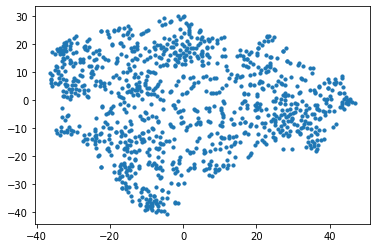

In [6]:
tsne = TSNE(init="pca")
X_valid_2D = tsne.fit_transform(encoder.predict(x_all))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

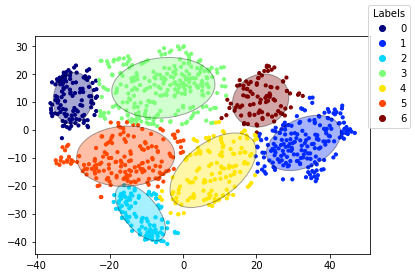

In [7]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
labels = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')

fig, ax = plt.subplots(1,1)
norm = mcolors.Normalize(0, n-1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)

In [14]:
k_label = 0
n_LPs = 3
gen = LP_datos()

k_index, = np.where(labels==k_label)
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))

NameError: name 'labels' is not defined

### 2.RNN AutoEncoder (No funciona bien)

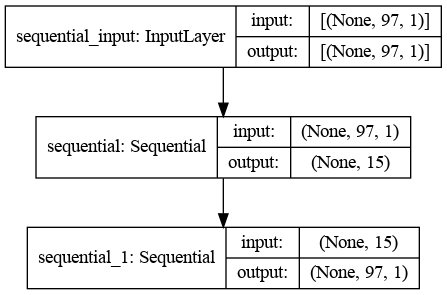

In [5]:
keras.backend.clear_session()
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, activation='relu', input_shape=[fq_size, 1]),
    keras.layers.LSTM(15, activation='relu')
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(fq_size, input_shape=[15]),
    keras.layers.LSTM(50, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid"))
])
rnn_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
keras.utils.plot_model(rnn_ae, show_shapes=True)

Epoch 1/100
17/17 [==============================] - 6s 275ms/step - loss: 0.6673 - val_loss: 0.5989
Epoch 2/100
17/17 [==============================] - 4s 245ms/step - loss: 0.4743 - val_loss: 0.4222
Epoch 3/100
17/17 [==============================] - 4s 255ms/step - loss: 0.4129 - val_loss: 0.3910
Epoch 4/100
17/17 [==============================] - 4s 252ms/step - loss: 0.3955 - val_loss: 0.3847
Epoch 5/100
17/17 [==============================] - 4s 253ms/step - loss: 0.3886 - val_loss: 0.3772
Epoch 6/100
17/17 [==============================] - 4s 257ms/step - loss: 0.3761 - val_loss: 0.3600
Epoch 7/100
17/17 [==============================] - 4s 258ms/step - loss: 0.3782 - val_loss: 0.3985
Epoch 8/100
17/17 [==============================] - 4s 266ms/step - loss: 0.3964 - val_loss: 0.3841
Epoch 9/100
17/17 [==============================] - 5s 266ms/step - loss: 0.3884 - val_loss: 0.3806
Epoch 10/100
17/17 [==============================] - 4s 261ms/step - loss: 0.3859 - val_lo

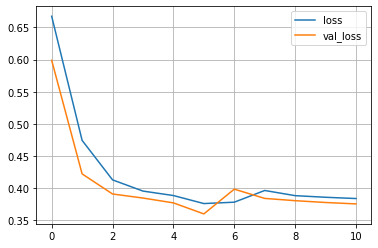

In [6]:
rnn_ae.compile(optimizer='adam', loss='binary_crossentropy')
history = rnn_ae.fit(X_train, X_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_test, X_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]
                )
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

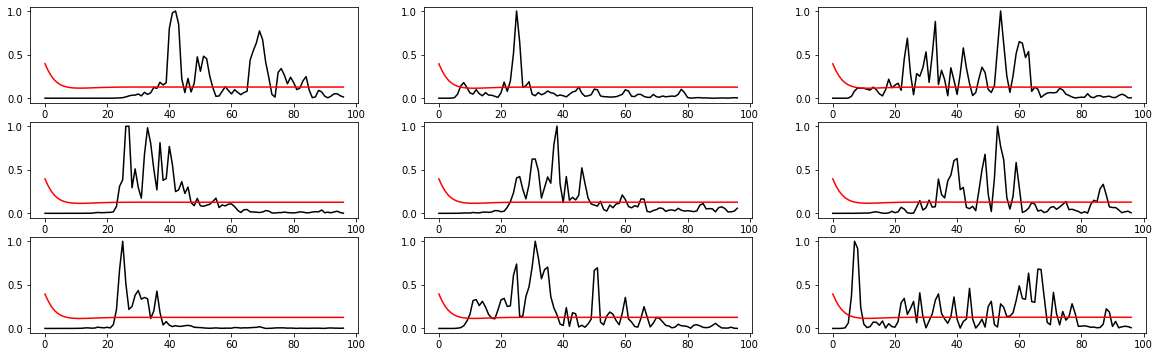

In [7]:
x_pred = rnn_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:,0], color='r')

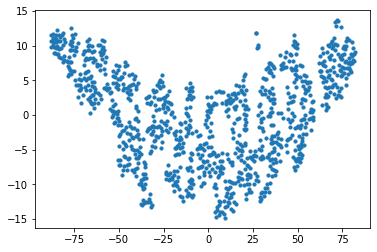

In [39]:
encoded_imgs = recurrent_encoder.predict(X_all)
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(encoded_imgs)
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 3.Deep AutoEncoder

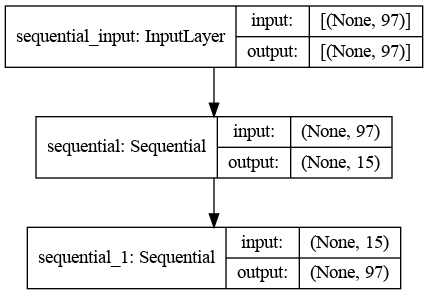

In [15]:
keras.backend.clear_session()
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(fq_size,)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(50, activation="selu"),
    keras.layers.Dense(15, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(50, activation="selu", input_shape=[15]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
keras.utils.plot_model(dropout_ae, show_shapes=True)
# dropout_ae.summary()

Epoch 1/200
17/17 [==============================] - 0s 9ms/step - loss: 0.6324 - val_loss: 0.5270
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 0.4561 - val_loss: 0.3792
Epoch 3/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3677 - val_loss: 0.3439
Epoch 4/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3490 - val_loss: 0.3359
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3430 - val_loss: 0.3311
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3384 - val_loss: 0.3268
Epoch 7/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3341 - val_loss: 0.3225
Epoch 8/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3301 - val_loss: 0.3183
Epoch 9/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3264 - val_loss: 0.3144
Epoch 10/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3227 - val_loss: 0.3113
Epoch 11/

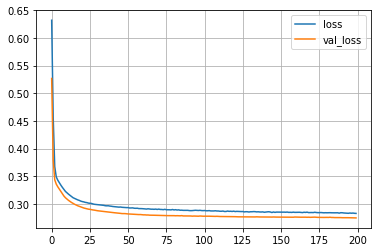

In [16]:
dropout_ae.compile(loss="binary_crossentropy", optimizer='adam')
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# %tensorboard --logdir logs
history = dropout_ae.fit(x_train, x_train, epochs=200, batch_size=32,
                         validation_data=(x_test, x_test))
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

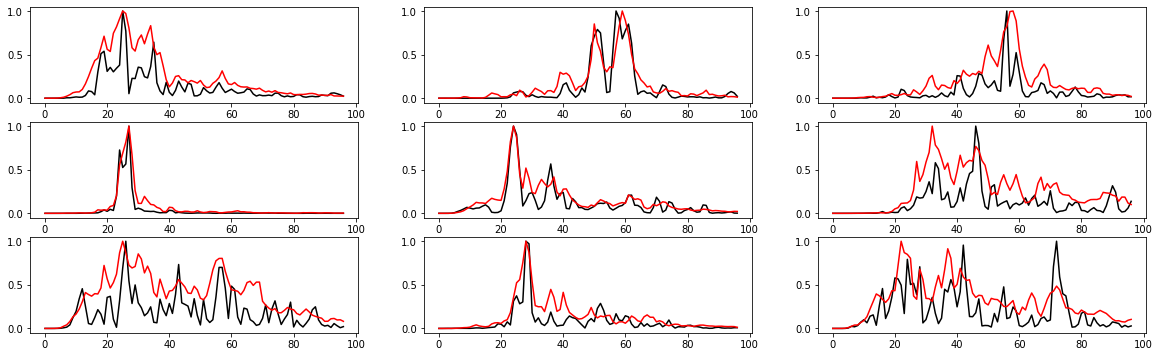

In [18]:
x_pred = dropout_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

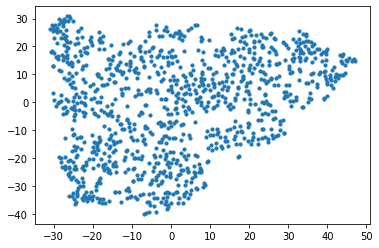

In [19]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(dropout_encoder.predict(x_all))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

 Akaike information criterion (AIC):  17545
 Bayesian information criterion (BIC):  17748


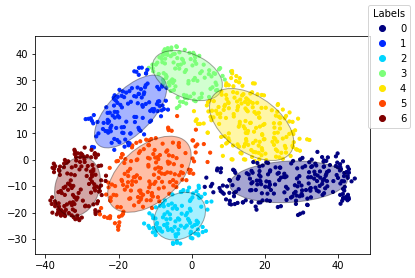

In [47]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
labels = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')

fig, ax = plt.subplots(1,1)
norm = mcolors.Normalize(0, n-1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)

[148 499 164]


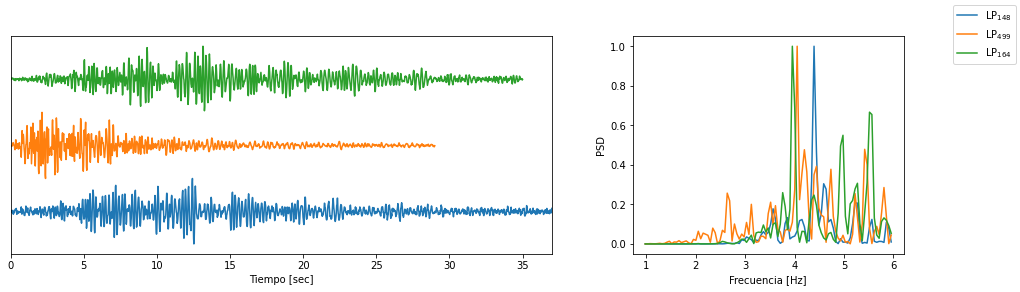

In [50]:
k_label = 2
n_LPs = 3
gen = LP_datos()

k_index, = np.where(labels==k_label)
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))

### 4.Sparse Autoencoder

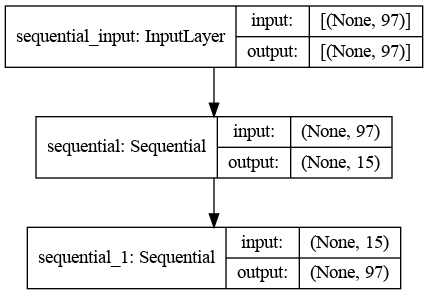

In [21]:
keras.backend.clear_session()
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fq_size,]),
    keras.layers.Dense(50, activation="selu"),
    keras.layers.Dense(15, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(50, activation="selu", input_shape=[15]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder], name='Sparse')
keras.utils.plot_model(sparse_ae, show_shapes=True)
# sparse_ae.summary()

In [22]:
sparse_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=['accuracy'])
history = sparse_ae.fit(x_train, x_train, epochs=200, batch_size=40,
                           validation_data=(x_test, x_test))

/home/ifm/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
14/14 [==============================] - 0s 10ms/step - loss: 0.6019 - accuracy: 0.0077 - val_loss: 0.4597 - val_accuracy: 0.0383
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.0479 - val_loss: 0.3637 - val_accuracy: 0.0364
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 0.3610 - accuracy: 0.0670 - val_loss: 0.3481 - val_accuracy: 0.0268
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.3535 - accuracy: 0.0651 - val_loss: 0.3440 - val_accuracy: 0.0824
Epoch 5/200
14/14 [==============================] - 0s 4ms/step - loss: 0.3512 - accuracy: 0.0862 - val_loss: 0.3422 - val_accuracy: 0.0421
Epoch 6/200
14/14 [==============================] - 0s 4ms/step - loss: 0.3501 - accuracy: 0.0747 - val_loss: 0.3414 - val_accuracy: 0.0268
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.0402 - val_loss: 0.3404 - val_accuracy: 0.0824
Epoch 8/200


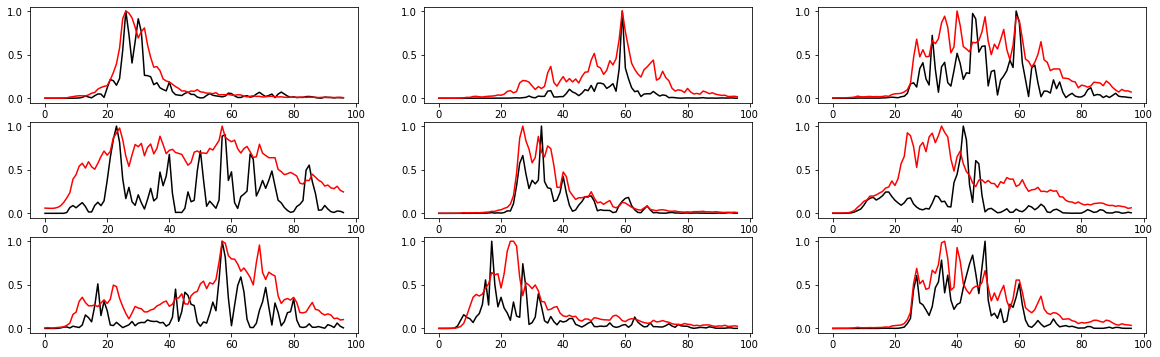

In [23]:
x_pred = sparse_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(sparse_encoder.predict(x_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 5.Convolutional AutoEncoder (Difícil de implementar)

In [ ]:
keras.backend.clear_session()
conv_encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=25, kernel_size=4, activation="selu", input_shape=[fq_size,1], padding="same"),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=12, kernel_size=1, activation='selu', padding='same'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=5, kernel_size=3, activation='selu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(25, activation='selu'),
    keras.layers.Reshape([25,1])
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv1D(5, kernel_size=4, activation='selu', input_shape=[25, 1], padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(12, kernel_size=4, activation='selu', padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(25, kernel_size=4, activation='selu', padding='same'),
    keras.layers.Conv1D(1, kernel_size=4, activation='sigmoid')
])

# keras.utils.plot_model(conv_encoder, show_shapes=True)
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
keras.utils.plot_model(conv_ae, show_shapes=True)
conv_ae.summary()

In [ ]:
conv_ae.compile(optimizer='adam', loss='binary_crossentropy')
history = conv_ae.fit(X_train, X_train,
            epochs=100,
            batch_size=32,
            shuffle=True,
            validation_data=(X_test, X_test))

In [ ]:
x_pred = conv_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, X_test.shape[0])
    ax.plot(x_test[n,:,0], color='k')
    ax.plot(x_pred[n,:,0], color='r')

In [ ]:
encoded_imgs = conv_encoder.predict(X_train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(encoded_imgs.reshape(encoded_imgs.shape[0],encoded_imgs.shape[1]))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 6.Variational AutoEncoder

In [24]:
keras.backend.clear_session()

K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

Model: "variational_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 97)]         0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 97)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 75)           7350        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           3800        dense_1[0][0]                    
________________________________________________________________________________

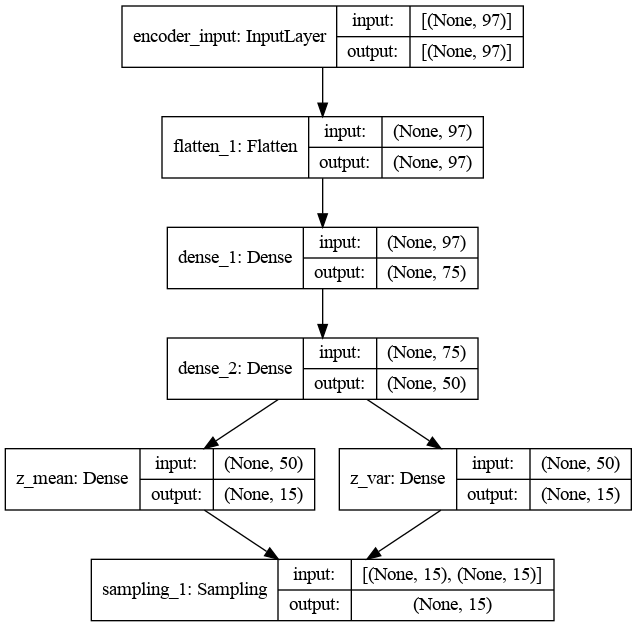

In [26]:
# encoder
inputs = keras.layers.Input(shape=(fq_size,), name='encoder_input')
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(75, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
z_mean = keras.layers.Dense(15, name='z_mean')(x)
z_logvar = keras.layers.Dense(15, name='z_var')(x)
z = Sampling()([z_mean, z_logvar])
variational_encoder = keras.models.Model(inputs = [inputs], 
                                         outputs=[z_mean, z_logvar, z],
                                         name='variational_encoder')
variational_encoder.summary()
keras.utils.plot_model(variational_encoder, show_shapes=True)

Model: "variational_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 75)                1200      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 97)                4947      
_________________________________________________________________
reshape (Reshape)            (None, 97)                0         
Total params: 9,947
Trainable params: 9,947
Non-trainable params: 0
_________________________________________________________________


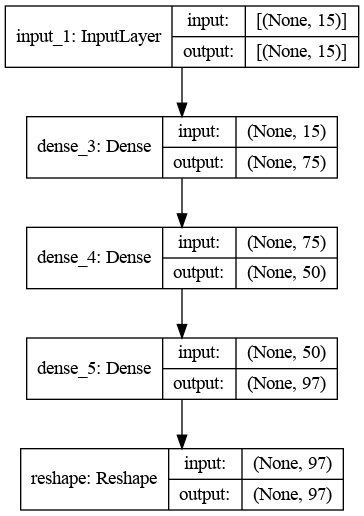

In [27]:
# decoder
latent_inputs = keras.layers.Input(shape=(15,))
x = keras.layers.Dense(75, activation='relu')(latent_inputs)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dense(fq_size, activation='sigmoid')(x)
outputs = keras.layers.Reshape([fq_size,])(x)

# instanceo el modelo del decoder
variational_decoder = keras.models.Model(inputs=[latent_inputs], outputs=[outputs], name='variational_decoder')
variational_decoder.summary()
keras.utils.plot_model(variational_decoder, show_shapes=True)

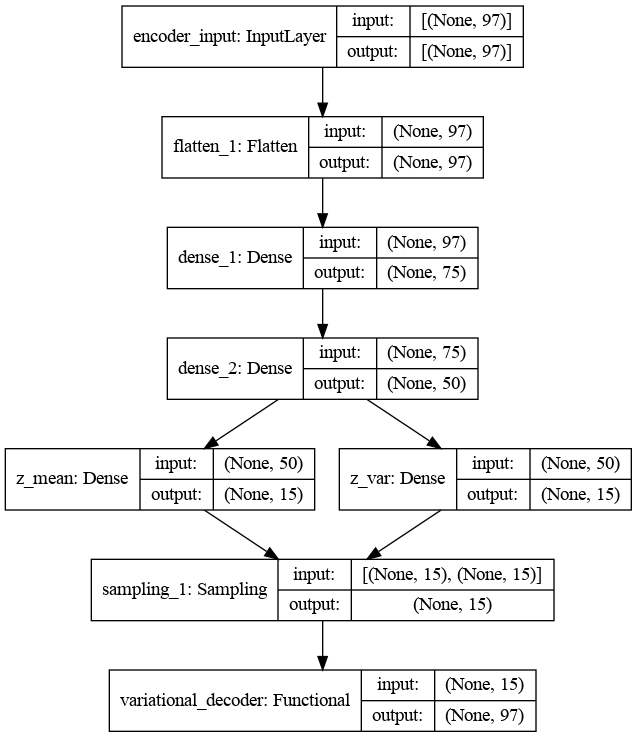

In [28]:
#el decoder es el modelo
#z es la variable definida como el tercer output del encoder
outputs = variational_decoder(z)

#autoencoder:
vae = keras.models.Model(inputs, outputs, name='vae_mlp')
keras.utils.plot_model(vae, show_shapes=True)

In [29]:
latent_loss = -0.5 * K.sum(
    1 + z_logvar - K.exp(z_logvar) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(latent_loss) / fq_size ) #agregamos la función de perdida latente
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")

Epoch 1/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3329 - val_loss: 0.3264
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3355 - val_loss: 0.3258
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3343 - val_loss: 0.3258
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.3336 - val_loss: 0.3267
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3347 - val_loss: 0.3255
Epoch 6/200
17/17 [==============================] - 0s 5ms/step - loss: 0.3353 - val_loss: 0.3257
Epoch 7/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3339 - val_loss: 0.3251
Epoch 8/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3340 - val_loss: 0.3239
Epoch 9/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3327 - val_loss: 0.3258
Epoch 10/200
17/17 [==============================] - 0s 4ms/step - loss: 0.3344 - val_loss: 0.3252
Epoch 11/

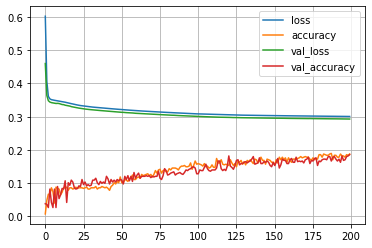

In [33]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = vae.fit(x_train, x_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_test, x_test),
        callbacks = [early_stopping_cb])

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

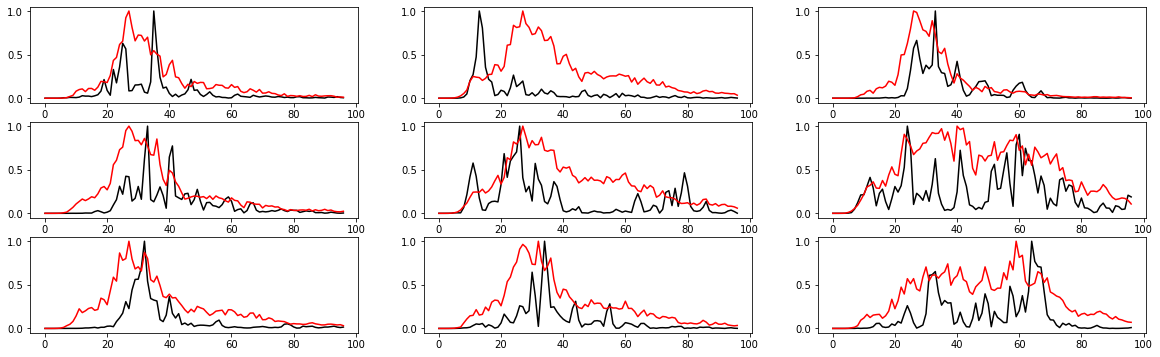

In [32]:
x_pred = vae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
z_mean, z_var, z = variational_encoder.predict(x_test, batch_size=32)
plt.scatter(z_mean[:, 0], z_mean[:, 1])

## Clasificación

Seleccionar un modelo sencillo como puede ser el Deep o el Simple y utilizar sus capas para poder entrenar un clasificador.

Mejorará la perfomance de esta implementación si la comparamos con el logistico?

Si combinamos los parametros que tenemos junto con los que se obtiene de aplicar el autoencoder, mejora el TSNE+GMM?